# Plotting feature importances

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, load_boston

from rfpimp import *

## Rent data set, classify interest in ad

In [2]:
df_all = pd.read_csv("data/rent-cls.csv") 

num_features = ['bathrooms','bedrooms','latitude','longitude','price']
target = 'interest_level'

df = df_all[num_features + [target]]
df_train, df_test = train_test_split(df, test_size=0.15)

X_train, y_train = df_train.drop('interest_level',axis=1), df_train['interest_level']
X_test, y_test = df_test.drop('interest_level',axis=1), df_test['interest_level']

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
#                            max_features=X_train.shape[1]-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1.0, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

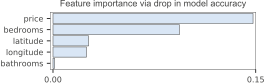

In [3]:
I = importances(rf, X_test, y_test)
plot_importances(I)

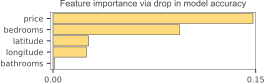

In [4]:
plot_importances(I, color='#FDDB7D')

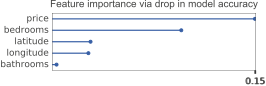

In [5]:
stemplot_importances(I, vscale=.7)

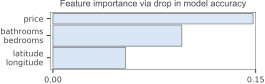

In [6]:
I = importances(rf, X_test, y_test, features=['price',['latitude','longitude']])
plot_importances(I)

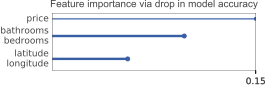

In [7]:
stemplot_importances(I, vscale=.7)

## Breast cancer data set, classify malignant/benign

In [8]:
cancer = load_breast_cancer()

X, y = cancer.data, cancer.target
# show first 5 columns only
# df = pd.DataFrame(X[:, 0:10], columns=cancer.feature_names[0:10])
df = pd.DataFrame(X, columns=cancer.feature_names)
#df['diagnosis'] = cancer.target
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.15)

cl = RandomForestClassifier(n_estimators=100)
cl.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### Default importances via gini/variance drop

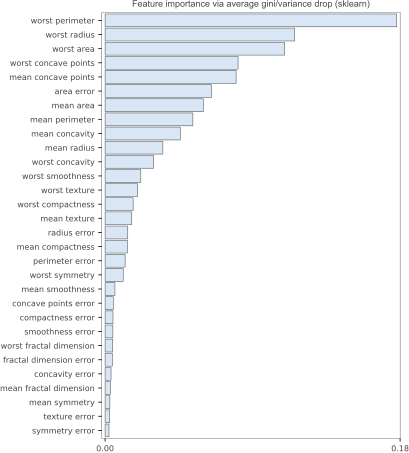

In [9]:
I = pd.DataFrame()

I['Feature'] = X_train.columns
I['Importance'] = cl.feature_importances_
I = I.sort_values('Importance', ascending=False)
I = I.set_index('Feature')
viz = plot_importances(I,
                 width=6,
#                 color='#FDDB7D',
#                 bgcolor='#F1F8FE',
                 title="Feature importance via average gini/variance drop (sklearn)")
viz.save('../article/images/cancer_dflt_imp.svg')
viz

### Permutation importance

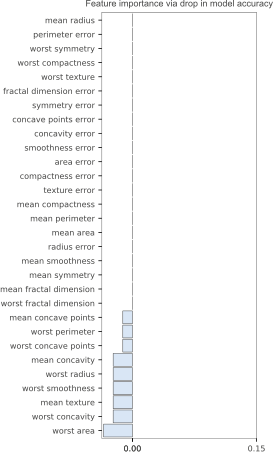

In [10]:
I = importances(cl, X_test, y_test)
viz = plot_importances(I)
viz.save('../article/images/cancer_imp.svg')
viz

### Drop column importance

In [ ]:
I = dropcol_importances(cl, X_train, y_train, X_test, y_test)
plot_importances(I)

### Drop column importance using OOB score

In [ ]:
I = oob_dropcol_importances(cl, X_train, y_train)
viz = plot_importances(I)
viz

This obviously means that the features are highly collinear. Verified via:

In [ ]:
viz = plot_corr_heatmap(X_train, figsize=(11,11), label_fontsize=9, value_fontsize=7)
viz.save('../article/images/cancer_corr.svg')
viz

Wow. And look at the predictability (R^2 or accuracy depending on column type) of the variables using other variables:

In [ ]:
pd.set_option('precision', 3)
D = feature_dependence_matrix(X_train, sort_by_dependence=True)

In [ ]:
D.columns

In [ ]:
D

In [ ]:
D = feature_dependence_matrix(X_train)

In [ ]:
viz = plot_dependence_heatmap(D, figsize=(11,10))
viz.save('../article/images/cancer_dep.svg')
viz